# Lesson 4C: External Disturbances

This notebook is designed to run in Google Colab or local Jupyter.

**Colab steps:** Open the notebook, run the setup cell below, then run cells top-to-bottom.

## Learning Objectives
- Model external disturbances applied to the system.
- Quantify how disturbances affect stability and tracking.
- Propose mitigation strategies (filtering, gain changes).

### Parameters (update as needed)
| Symbol | Meaning | Example |
| --- | --- | --- |
| m_c | Cart mass | 0.5 kg |
| m_p | Pendulum mass | 0.2 kg |
| l | Pendulum length | 0.3 m |
| g | Gravity | 9.81 m/s^2 |
| dt | Sample time | 0.01 s |

---
## Lesson Content

In [1]:
# Install required packages (Colab)
!pip -q install numpy scipy matplotlib


## Robustness stress test
Keep gains fixed and stress the model:
- Increase mass
- Increase friction
- Add delay

Score your controller on:
- Stability
- Energy usage (control effort)
- Robustness to mismatch

Deliverable: which mismatch hurt most and why.


# Investigate the Effect of External Disturbances

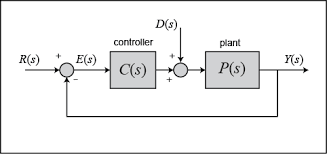

In control systems, disturbances are external influences or unexpected changes that affect the system's behavior. These influences can disrupt the system's ability to maintain its desired state or trajectory. Disturbances are typically unpredictable and originate from the environment or the system itself.

Types of Disturbances
- **Impulse**: A sudden force applied to the system at a specific time step. E.g. brief knock on pole.  
- **Constant**: A steady external force pushing in one direction. E.g., steady wind.
- **Ramp**: An external force that increases gradually over time, typically in a linear manner. E.g. temperature increase in a room due to external heating.

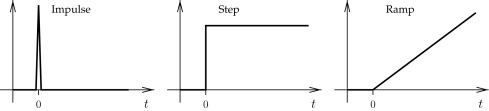

In [2]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
from pathlib import Path

class InvertedPendulum:
    def __init__(self, dt=0.02):
        # System constants
        self.gravity = 9.8        # Acceleration due to gravity (m/s^2)
        self.mass_cart = 1.0      # Mass of the cart (kg)
        self.mass_pole = 0.1      # Mass of the pole (kg)
        self.length = 0.5         # Length of the pole (m)
        self.dt = dt              # Time step (s)

        # State variables: [cart position, cart velocity, pole angle, pole angular velocity]
        self.state = np.zeros(4)

        self.save_dir = 'temp/'
        Path(self.save_dir).mkdir(parents=True, exist_ok=True)

    def reset(self):
        """Resets the system state to a small random initial condition."""
        self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        return self.state

    def step(self, force):
        """
        Takes an action (force) and updates the system state.
        Args:
            force (float): Force applied to the cart (N)
        Returns:
            np.array: Updated state [cart position, cart velocity, pole angle, pole angular velocity]
        """
        x, x_dot, theta, theta_dot = self.state

        # Constants for easier calculations
        total_mass = self.mass_cart + self.mass_pole
        pole_mass_length = self.mass_pole * self.length
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)

        # # Equations of motion
        # temp = (force + pole_mass_length * theta_dot**2 * sin_theta) / total_mass
        # theta_acc = (self.gravity * sin_theta - cos_theta * temp) / (
        #     self.length * (4.0 / 3.0 - self.mass_pole * cos_theta**2 / total_mass)
        # )

        # x_acc = temp - pole_mass_length * theta_acc * cos_theta / total_mass

        x_acc = (force + self.mass_pole*sin_theta*(self.length*theta_dot**2 - self.gravity * cos_theta)) / (self.mass_cart + self.mass_pole * sin_theta**2)
        theta_acc = (-1*force * cos_theta - self.mass_pole*self.length*theta_dot**2*sin_theta*cos_theta + (self.mass_cart + self.mass_pole)*self.gravity*sin_theta) /  (self.length*(self.mass_cart + self.mass_pole * sin_theta**2))

        # Update state using Euler integration
        x += self.dt * x_dot
        x_dot += self.dt * x_acc
        theta += self.dt * theta_dot
        theta_dot += self.dt * theta_acc

        self.state = np.array([x, x_dot, theta, theta_dot])
        return self.state

    def render(self, file_idx=0, title="Inverted Pendulum"):
        """
        Plots the cart and pole position with a specified title for Colab.

        Args:
            title (str): Title to display on the plot.
        """
        x, _, theta, _ = self.state

        # Cart dimensions
        cart_width = 0.3
        cart_height = 0.2

        # Pole position
        pole_x = x + self.length * np.sin(theta)
        pole_y = self.length * np.cos(theta)

        # Clear previous output
        clear_output(wait=True)

        # Create a new figure
        plt.figure(figsize=(8, 4))
        plt.xlim(-2, 2)
        plt.ylim(-1, 1)
        plt.grid()

        # Draw the cart
        cart_rect = Rectangle((x - cart_width / 2, -cart_height / 2), cart_width, cart_height, color="blue")
        plt.gca().add_patch(cart_rect)

        # Draw the pole
        plt.plot([x, pole_x], [0, pole_y], color="red", linewidth=2)

        # Draw the pivot point
        plt.plot(x, 0, 'ko', markersize=5)

        # Set the title
        plt.title(title)

        # # Save figure
        # plt.savefig(self.save_dir + str(file_idx) + '.png')

        # Display the updated plot
        plt.show()


**Expected output:**
- State plots show the disturbance onset and a recovery toward the setpoint after control action.

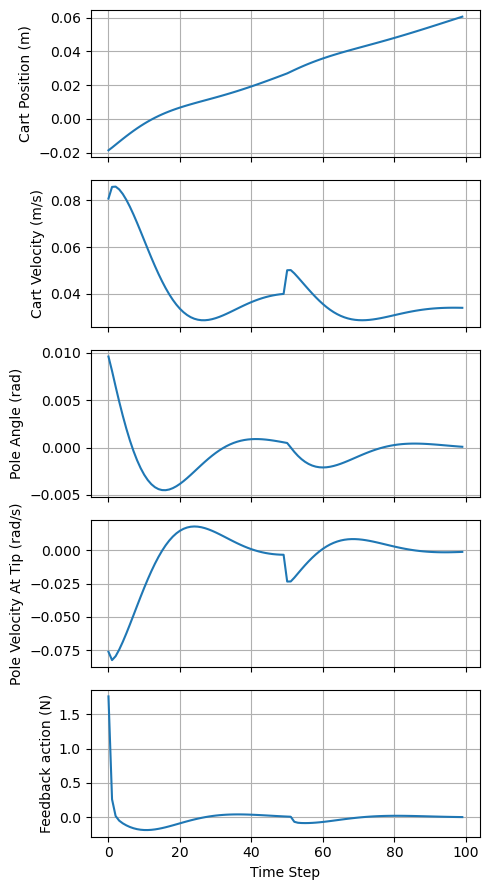

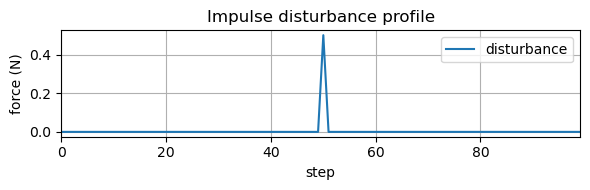

In [3]:
## Impulse Disturbances

import IPython
from IPython.display import Image
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math

# Create an instance of the inverted pendulum system
pendulum = InvertedPendulum()

# Reset the system to a random initial state
states = pendulum.reset()

## Choose disturbance type
disturbance_type = "impulse"  # "impulse", "constant", "ramp"
# Introduce disturbance at a specific time step
disturbance_magnitude = 0.5  # Adjust the magnitude of the impulse
disturbance_time = 50      # Time step at which to apply the impulse
disturbance_rate = 0.1 # Rate of increasing disturbance with each step (for ramp only)

states_list = []  # List to save states for plot later
action_list = []  # List to save actions for plot later
disturbance_list = []  # Track applied disturbance

SIMULATION_STEPS = 100  # Number of time steps to take in simulation

Kp = 30  # Proportional Gain
Kd = 150 # Derivative Gain
setpoint = 0.0  # Desired pole angle

# Previous error for derivative calculation
prev_error = 0

# Simulate the system with random forces and render the results
for step in range(SIMULATION_STEPS):
    if step >= disturbance_time:
        if disturbance_type == "impulse":
            added_disturbance = disturbance_magnitude
            if step > disturbance_time:
                added_disturbance = 0.0
        elif disturbance_type == "constant":
            added_disturbance = disturbance_magnitude
        elif disturbance_type == "ramp":
            added_disturbance = disturbance_magnitude * disturbance_rate * (step - disturbance_time)
    else:
        added_disturbance = 0.0

    error = setpoint - states[2]  # compute the error between desired pole angle to observed pole angle
    derivative = (error - prev_error)  # Calculate derivative of the error

    action = -1 * (Kp * error + Kd * derivative)  # PD controller

    states = pendulum.step(action + added_disturbance)  # Apply action on cart

    # Saving for plots later
    states_list.append(states)
    action_list.append(action)
    disturbance_list.append(added_disturbance)

    prev_error = error  # Update previous error


# Plotting
num_states = len(states_list[0])  # Number of observations per step
fig, axes = plt.subplots(num_states + 1, 1, sharex=True, figsize=(5, 2 * num_states + 1))

# Y-axis labels
y_labels = ["Cart Position (m)", "Cart Velocity (m/s)", "Pole Angle (rad)", "Pole Velocity At Tip (rad/s)"]

for i in range(num_states):
    states_values = [s[i] for s in states_list]
    axes[i].plot(states_values)
    axes[i].set_ylabel(y_labels[i])
    axes[i].grid(True)

# plotting control signal
axes[-1].plot(action_list)
axes[-1].set_ylabel('Feedback action (N)')
axes[-1].grid(True)

axes[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()

# Plot disturbance profile (aligned with simulation steps)
step_idx = np.arange(SIMULATION_STEPS)
plt.figure(figsize=(6, 2))
plt.plot(step_idx, disturbance_list, label='disturbance')
plt.title('Impulse disturbance profile')
plt.xlabel('step')
plt.ylabel('force (N)')
plt.xlim(0, SIMULATION_STEPS - 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Task**: Effects of Disturbances to the System
- Introduce different types of disturbances (e.g., impulse, constant, ramp, or noise) into the control system.
- Observe how the controller handle each disturbance.
- Which type of disturbance was the most challenging for each controller? Why?
- What changes to the controller could improve disturbance rejection?

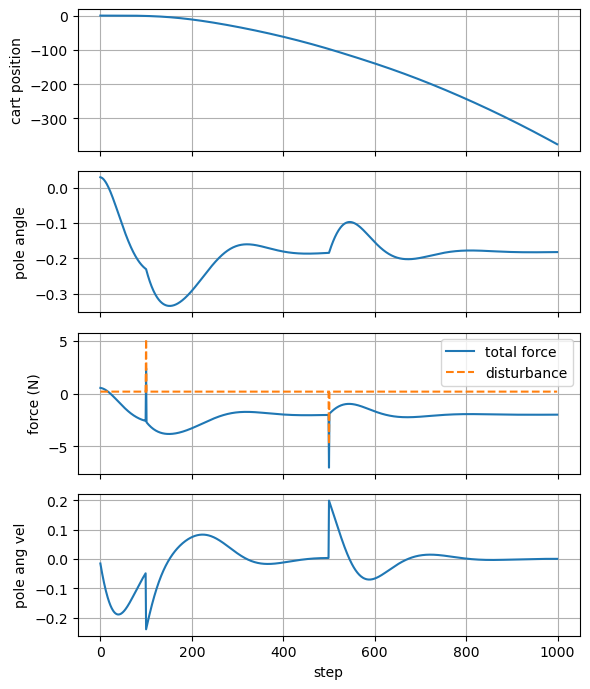

In [4]:
# Disturbance response with a slightly underdamped PD controller

# Controller gains (tuned for slight underdamping)
Kp = 12.0
Kd = 0.6

pendulum = InvertedPendulum(dt=0.02)
state = pendulum.reset()

steps = 1000

# Disturbance profile: impulses + small bias
external_force = np.zeros(steps)
external_force[100] = 5.0
external_force[500] = -5.0
external_force += 0.2  # constant bias

states = []
controls = []

for k in range(steps):
    x, x_dot, theta, theta_dot = state

    # PD control on pole angle
    control = (Kp * theta + Kd * theta_dot)

    # Total force includes disturbance
    total_force = control + external_force[k]
    state = pendulum.step(total_force)

    states.append(state)
    controls.append(total_force)

states = np.array(states)

# Plot results
fig, axes = plt.subplots(4, 1, figsize=(6, 7), sharex=True)
axes[0].plot(states[:, 0])
axes[0].set_ylabel('cart position')
axes[0].grid(True)

axes[1].plot(states[:, 2])
axes[1].set_ylabel('pole angle')
axes[1].grid(True)

axes[2].plot(controls, label='total force')
axes[2].plot(external_force, '--', label='disturbance')
axes[2].set_ylabel('force (N)')
axes[2].legend()
axes[2].grid(True)

axes[3].plot(states[:, 3])
axes[3].set_ylabel('pole ang vel')
axes[3].set_xlabel('step')
axes[3].grid(True)

plt.tight_layout()
plt.show()


## Other disturbance types
Explore how the same controller behaves under constant bias, ramp, and noise disturbances.


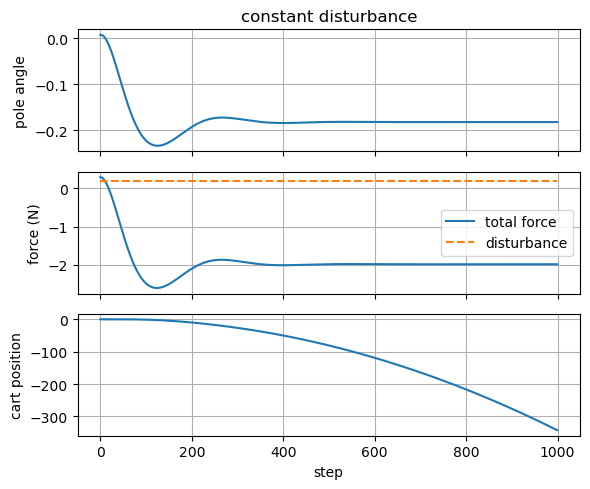

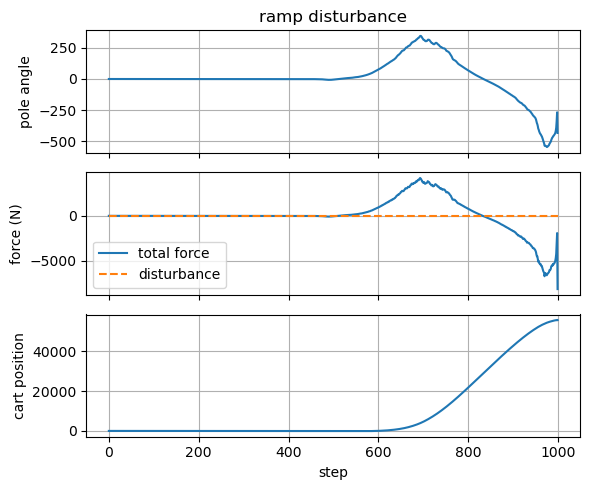

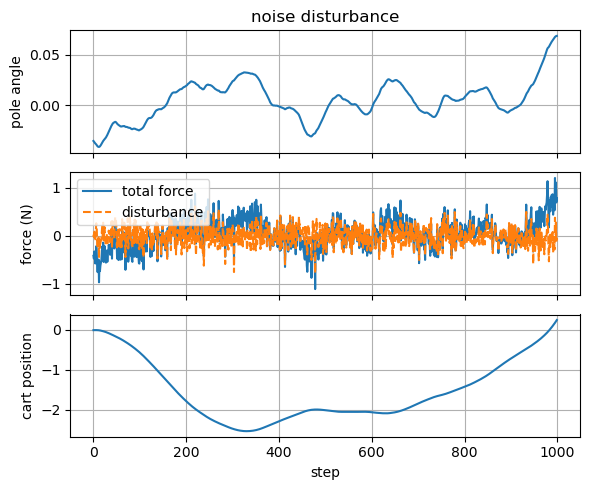

In [5]:
# Constant, ramp, and noise disturbances

steps = 1000

# Disturbance profiles
constant_disturbance = 0.2 * np.ones(steps)

ramp_disturbance = np.linspace(0.0, 1.0, steps)

rng = np.random.default_rng(0)
noise_disturbance = 0.2 * rng.standard_normal(steps)

profiles = {
    'constant': constant_disturbance,
    'ramp': ramp_disturbance,
    'noise': noise_disturbance,
}

for name, disturbance in profiles.items():
    pendulum = InvertedPendulum(dt=0.02)
    state = pendulum.reset()

    states = []
    controls = []

    for k in range(steps):
        x, x_dot, theta, theta_dot = state
        control = (Kp * theta + Kd * theta_dot)
        total_force = control + disturbance[k]
        state = pendulum.step(total_force)
        states.append(state)
        controls.append(total_force)

    states = np.array(states)

    fig, axes = plt.subplots(3, 1, figsize=(6, 5), sharex=True)
    axes[0].plot(states[:, 2])
    axes[0].set_ylabel('pole angle')
    axes[0].set_title(f'{name} disturbance')
    axes[0].grid(True)

    axes[1].plot(controls, label='total force')
    axes[1].plot(disturbance, '--', label='disturbance')
    axes[1].set_ylabel('force (N)')
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(states[:, 0])
    axes[2].set_ylabel('cart position')
    axes[2].set_xlabel('step')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


## Stress-test reflection
Report which parameter change caused the biggest degradation and explain the mechanism.


---
## Checkpoints
- Disturbance effects are visible in time responses.
- Mitigation steps improve robustness measurably.

## Common Pitfalls
- Using disturbance magnitudes that obscure system behavior.
- Attributing noise to instability without analysis.